In [12]:
# Import required libraries

import pickle
import os
import pandas as pd
import numpy as np

In [13]:
## 0 Read data from simulator

path = os.getcwd()
# name = 'data\data_20241022_1848_case4'
# name = 'data\data_20241104_1854_case8'
# name = 'data\data_20241220_1204_case10'
# name = 'data\data_240712_1026_case4'
name = 'data\data_20250527_1113_case10'
path_res = os.path.join(path, name)

with open(os.path.join(path_res, 'mat_res.pkl'),'rb') as handle:
		mat_res_pkl = pickle.load(handle)

mat_res_raw = pd.DataFrame.from_dict(mat_res_pkl)
mat_res_raw.keys()

Index(['BC', 'COORD_c', 'COORD', 'ELEMENTS', 'MATK', 'fe', 'GEOMA', 'GEOMK',
       'MASK', 'NODESG', 'POST', 'gauss_order', 'na', 'sig_g', 'eps_g', 'ux',
       'uy', 'uz', 'thx', 'thy', 'thz', 'De_tot', 'L/t', 'CC', 'F', 'rho',
       't_1', 'nl', 'mat', 's', 'E_1', 'E_2', 'F_N', 't_2', 'nu_1', 'nu_2',
       'L', 'B', 'ms', 'fsy', 'fsu', 'Es', 'Esh', 'D', 'tb0', 'tb1', 'ect',
       'ec0', 'fcp', 'fct', 'SN', 'EN'],
      dtype='object')

In [14]:
## 1 Extract relevant data for ML (only generalised strains and stresses)

# mat_res_raw.keys()
mat_res_rel_sig = mat_res_raw['sig_g']
mat_res_rel_eps = mat_res_raw['eps_g']
mat_res_rel_t = mat_res_raw['t_1']
if mat_res_raw['mat'][0] == 3:
    mat_res_rel_t = mat_res_raw[['t_1', 'rho', 'CC', 'E_1', 'tb0', 'tb1', 'ect', 'ec0', 'fcp', 'fct']].to_numpy()
mat_res_rel_SN = mat_res_raw['SN']
mat_res_rel_EN = mat_res_raw['EN']
mat_res_rel_De = mat_res_raw['De_tot']
mat_res_rel = pd.concat([mat_res_rel_sig, mat_res_rel_eps], axis = 1)
# mat_res_rel.head()
print(mat_res_rel_sig.shape[0])

90


In [15]:
## 2 Converting all nodal data into row entries of the data set
from utils import extend_elements, extend_elements_t

mat_res_rel_sig_n = extend_elements(mat_res_rel_sig, 'sig')
mat_res_rel_eps_n = extend_elements(mat_res_rel_eps, 'eps')
mat_res_rel_t_n, num_elem = extend_elements_t(mat_res_rel_t, mat_res_rel_eps, 't')
mat_res_rel_SN_n, num_elem = extend_elements_t(mat_res_rel_SN, mat_res_rel_eps, 't')
mat_res_rel_EN_n, num_elem = extend_elements_t(mat_res_rel_EN, mat_res_rel_eps, 'EN')
mat_res_rel_De_n, num_elem = extend_elements_t(mat_res_rel_De, mat_res_rel_eps, 'De')

mat_res_rel_n = pd.concat([mat_res_rel_sig_n, mat_res_rel_eps_n], axis = 1)
# mat_res_rel.head()

In [16]:
## 3 Determine data points per bin, create mask

from utils import binning, mask_data, cutoff_data
cutoff = False                      # if True, the data will be cut off, if False: entire data set will be used
gauss_order_cut = True

path_plt = os.path.join(path, 'plots')
n_bins = 50

if cutoff:
    sig_per_bin, sig_i_per_bin, binlist_sig = binning(mat_res_rel_sig_n, n_bins, path_plt, showplt=False)
    eps_per_bin, eps_i_per_bin, binlist_eps = binning(mat_res_rel_eps_n, n_bins, path_plt, showplt=False)

    mask_sig = mask_data(sig_per_bin, sig_i_per_bin, binlist_sig, mat_res_rel_sig_n, 0.8)
    mask_eps = mask_data(eps_per_bin, eps_i_per_bin, binlist_eps, mat_res_rel_eps_n, 0.8)


In [17]:
## 4a -  Retain new, more uniform data set by cutoff

if cutoff:
    new_data_sig = cutoff_data(mat_res_rel_sig_n, mask_sig, mask_eps, 1, n_bins, path_plt)
    new_data_eps = cutoff_data(mat_res_rel_eps_n, mask_sig, mask_eps, 1, n_bins, path_plt)
    new_data_t = cutoff_data(mat_res_rel_t_n, mask_sig, mask_eps, 2, n_bins, path_plt)
    new_data_De = cutoff_data(mat_res_rel_De_n, mask_sig, mask_eps, 2, n_bins, path_plt)
    new_data_SN = cutoff_data(mat_res_rel_SN_n, mask_sig, mask_eps, 2, n_bins, path_plt)
    new_data_EN = cutoff_data(mat_res_rel_EN_n, mask_sig, mask_eps, 2, n_bins, path_plt)
if gauss_order_cut:
    new_data_sig = mat_res_rel_sig_n.iloc[::4,:]
    new_data_eps = mat_res_rel_eps_n.iloc[::4,:]
    new_data_t = mat_res_rel_t_n.iloc[::4,:]
    new_data_De = mat_res_rel_De_n.iloc[::4,:]
    new_data_SN = mat_res_rel_SN_n.iloc[::4,:]
    new_data_EN = mat_res_rel_EN_n.iloc[::4,:]

else: 
    new_data_sig = mat_res_rel_sig_n
    new_data_eps = mat_res_rel_eps_n
    new_data_t = mat_res_rel_t_n
    new_data_De = mat_res_rel_De_n
    new_data_SN = mat_res_rel_SN_n
    new_data_EN = mat_res_rel_EN_n

Amount of simulations before cut-off: (90,)
Amount of simulations after cut-off: (90,)


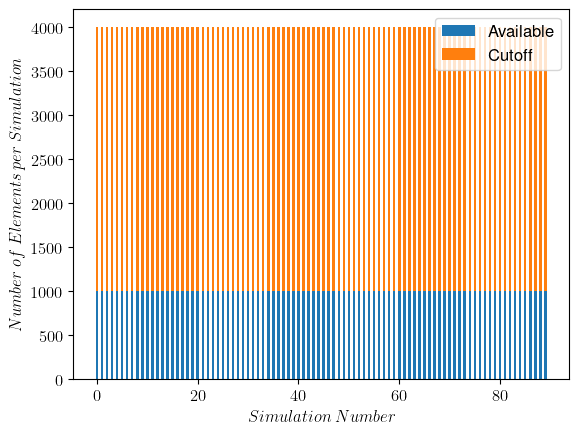

(8,)


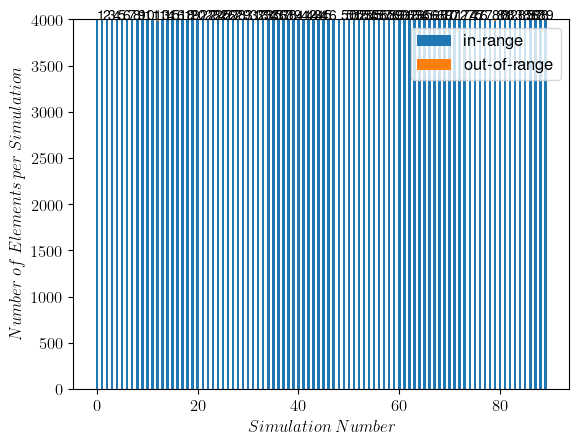

In [18]:
# 4b - Plot simulations (and within it amount of elements available for full simulation of example)
from utils import bar_id, bar_range, boxplot_compar

bar_id(new_data_EN, new_data_SN, num_elem)
bar_range(mat_res_rel_sig_n, mat_res_rel_eps_n, mat_res_rel_SN_n, new_data_sig, new_data_eps, new_data_SN, num_elem)
# boxplot_compar(mat_res_rel_sig_n, new_data_sig, 0, 'sig')

In [19]:
# 4c - Augment data set by adding different sig to same generated eps (with analytical solution)

from utils import D_an

augment = False
if augment:
    t = np.array([50, 60, 80, 140])
    sig_add = np.zeros((len(t)*new_data_sig.shape[0], new_data_sig.shape[1]))
    eps_add = np.zeros((len(t)*new_data_eps.shape[0], new_data_eps.shape[1]))
    t_add = np.zeros((len(t)*new_data_eps.shape[0], new_data_t.shape[1]))
    D_add = np.zeros((len(t)*new_data_eps.shape[0], new_data_De.shape[1]))
    for j in range(len(t)):
        for i in range(new_data_eps.shape[0]):
            sig_add[i+new_data_sig.shape[0]*j,:], D_add[i+new_data_sig.shape[0]*j,:] = D_an(new_data_eps.iloc[i].to_numpy(), t[j])
            eps_add[i+new_data_sig.shape[0]*j,:] = new_data_eps.iloc[i].to_numpy()
            t_add[i+new_data_sig.shape[0]*j,:] = t[j]
            

    newadd_data_eps = np.concatenate([new_data_eps.to_numpy(), eps_add], axis = 0)
    newadd_data_sig = np.concatenate([new_data_sig.to_numpy(), sig_add], axis = 0)
    newadd_data_t = np.concatenate([new_data_t.to_numpy(), t_add], axis = 0)
    newadd_data_De = np.concatenate([new_data_De.to_numpy(), D_add], axis = 0)

In [20]:
## 5 - Save new data to pickle

path_new_data = os.path.join(path, 'new_data')

new_data_eps.to_pickle(os.path.join(path_new_data,'new_data_eps.pkl'))
new_data_sig.to_pickle(os.path.join(path_new_data,'new_data_sig.pkl'))
new_data_t.to_pickle(os.path.join(path_new_data,'new_data_t.pkl'))
new_data_De.to_pickle(os.path.join(path_new_data,'new_data_De.pkl'))

# for synthetically augmented data set
if augment: 
    pd.DataFrame(newadd_data_eps).to_pickle(os.path.join(path_new_data,'newadd_data_eps.pkl'))
    pd.DataFrame(newadd_data_sig).to_pickle(os.path.join(path_new_data,'newadd_data_sig.pkl'))
    pd.DataFrame(newadd_data_t).to_pickle(os.path.join(path_new_data,'newadd_data_t.pkl'))
    pd.DataFrame(newadd_data_De).to_pickle(os.path.join(path_new_data,'newadd_data_De.pkl'))

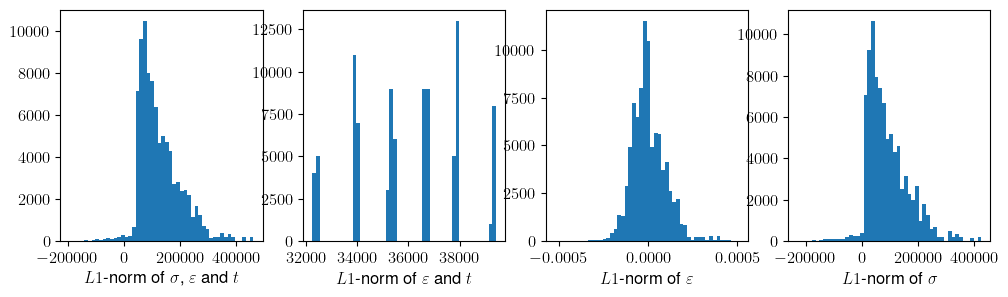

In [21]:
## 6 - Create L1-norm histogram of entire input vector

import matplotlib.pyplot as plt

# calculate L1
L1_eps = new_data_eps.sum(axis=1)
L1_sig = new_data_sig.sum(axis=1)
L1_t = new_data_t.sum(axis=1)
L1_De = new_data_De.sum(axis=1)

L1_all = L1_eps+L1_sig+L1_t+L1_De
L1_inpout = L1_eps+L1_sig+L1_t
# plt.hist(L1_all, bins=50)
fig, ax = plt.subplots(ncols = 4, figsize = [12, 3])
ax[0].hist(L1_inpout, bins=50)
ax[0].set_xlabel(r'$L1$-norm of $\sigma$, $\varepsilon$ and $t$')
ax[1].hist(L1_eps+L1_t, bins=50)
ax[1].set_xlabel(r'$L1$-norm of $\varepsilon$ and $t$')
ax[2].hist(L1_eps, bins=50)
ax[2].set_xlabel(r'$L1$-norm of $\varepsilon$')
ax[3].hist(L1_sig, bins=50)
ax[3].set_xlabel(r'$L1$-norm of $\sigma$')
plt.show()
# quite uniform!!

In [22]:
# if data should be saved to folder instead of being overwritten with the next simulation, use save_folder = True

from datetime import datetime
import shutil

save_folder = True

if save_folder:
    relative_path = ['new_data\\new_data_eps.pkl', 'new_data\\new_data_sig.pkl', 'new_data\\new_data_t.pkl', 'new_data\\new_data_De.pkl',
                    'new_data\\newadd_data_eps.pkl', 'new_data\\newadd_data_sig.pkl', 'new_data\\newadd_data_t.pkl', 'new_data\\newadd_data_De.pkl',]
    
    for i in range(len(relative_path)):
        source_folder = os.path.dirname(relative_path[i])
        file_name = os.path.basename(relative_path[i])

        current_time = datetime.now()
        new_folder = current_time.strftime("data_%Y%m%d_%H%M_case"+'xx')
        new_folder_path = os.path.join(source_folder, new_folder)

        os.makedirs(new_folder_path, exist_ok=True)

        destination_path = os.path.join(new_folder_path, file_name)
        shutil.copy(relative_path[i], destination_path)

        print('File', i, 'is copied to', destination_path)

File 0 is copied to new_data\data_20250527_1144_casexx\new_data_eps.pkl
File 1 is copied to new_data\data_20250527_1144_casexx\new_data_sig.pkl
File 2 is copied to new_data\data_20250527_1144_casexx\new_data_t.pkl
File 3 is copied to new_data\data_20250527_1144_casexx\new_data_De.pkl
File 4 is copied to new_data\data_20250527_1144_casexx\newadd_data_eps.pkl
File 5 is copied to new_data\data_20250527_1144_casexx\newadd_data_sig.pkl
File 6 is copied to new_data\data_20250527_1144_casexx\newadd_data_t.pkl
File 7 is copied to new_data\data_20250527_1144_casexx\newadd_data_De.pkl
